In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Figure out how to get the mask of the bar

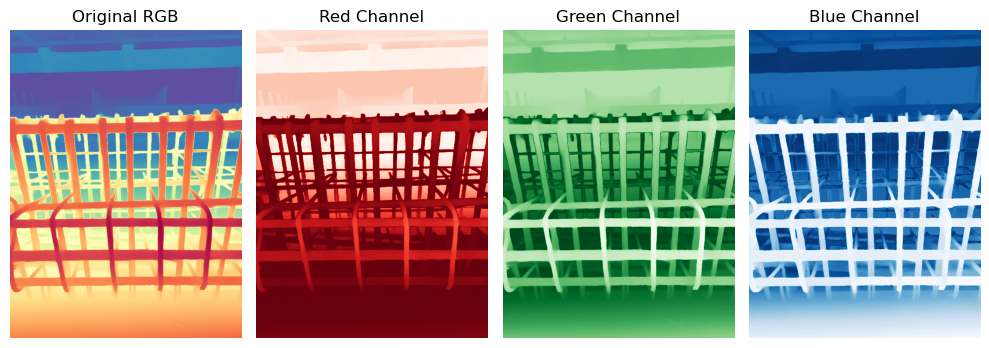

In [79]:
depth_map = cv2.imread('depth_map_comparison/0.5m_pred/depth_anything_vitl/20250502_132954.png', cv2.IMREAD_COLOR)
depth_map = cv2.cvtColor(depth_map, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
depth_map = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

red_channel = depth_map[:,:,0]
green_channel = depth_map[:,:,1] 
blue_channel = depth_map[:,:,2]

# Let's examine which channel has the most depth variation
plt.figure(figsize=(10, 5))

plt.subplot(1, 4, 1)
plt.imshow(depth_map)
plt.title('Original RGB')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(red_channel, cmap='Reds')
plt.title('Red Channel')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(green_channel, cmap='Greens')
plt.title('Green Channel')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(blue_channel, cmap='Blues')
plt.title('Blue Channel')
plt.axis('off')

plt.tight_layout()
plt.show()

It seems that blue has the better representation of segmenting the closer bar.  

Next steps: 
- Try to get the shape of the bar by setting a thresholds

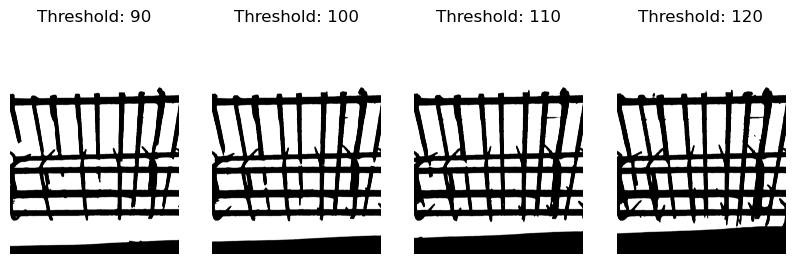

In [ ]:
plt.figure(figsize=(10, 5))
thresholds = [90, 100, 110, 120]
for i in range(len(thresholds)):
    segment = cv2.threshold(blue_channel, thresholds[i], 255, cv2.THRESH_BINARY)[1]
    
    plt.subplot(1, len(thresholds), i + 1)
    plt.imshow(segment, cmap='gray')
    plt.title(f'Threshold: {thresholds[i]}')
    plt.axis('off')

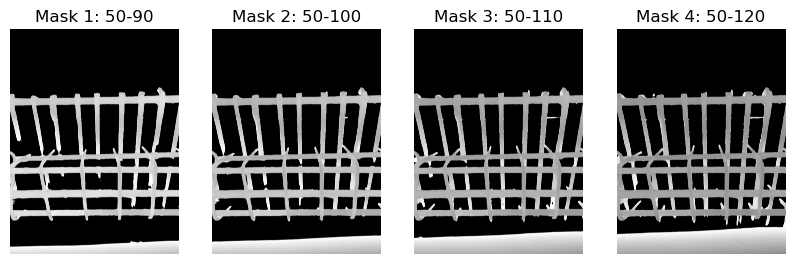

In [80]:
plt.figure(figsize=(10, 5))
thresholds = [[50, 90], [50, 100], [50, 110], [50, 120]]
for i in range(len(thresholds)):
    lower_bound = thresholds[i][0]
    upper_bound = thresholds[i][1]
    
    # Create a mask for the current threshold range
    mask = (blue_channel >= lower_bound) & (blue_channel < upper_bound)
    
    # Create a segmented image based on the mask
    segment = np.zeros_like(blue_channel)
    segment[mask] = blue_channel[mask]
    
    plt.subplot(1, len(thresholds), i + 1)
    plt.imshow(segment, cmap='gray')
    plt.title(f'Mask {i + 1}: {thresholds[i][0]}-{thresholds[i][1]}')
    plt.axis('off')

I think by setting the threshold to be 50 to 110 has the better representation of the bar, it catches the two layers of bar but without too many miscellaneous details.  

Next steps:
- Try to segment the first and second layer.
- Set the two layers into different images

Closest point location: Row 1054, Col 2679
Closest point warmness: 178.00
Closest point RGB: [245 109  67]


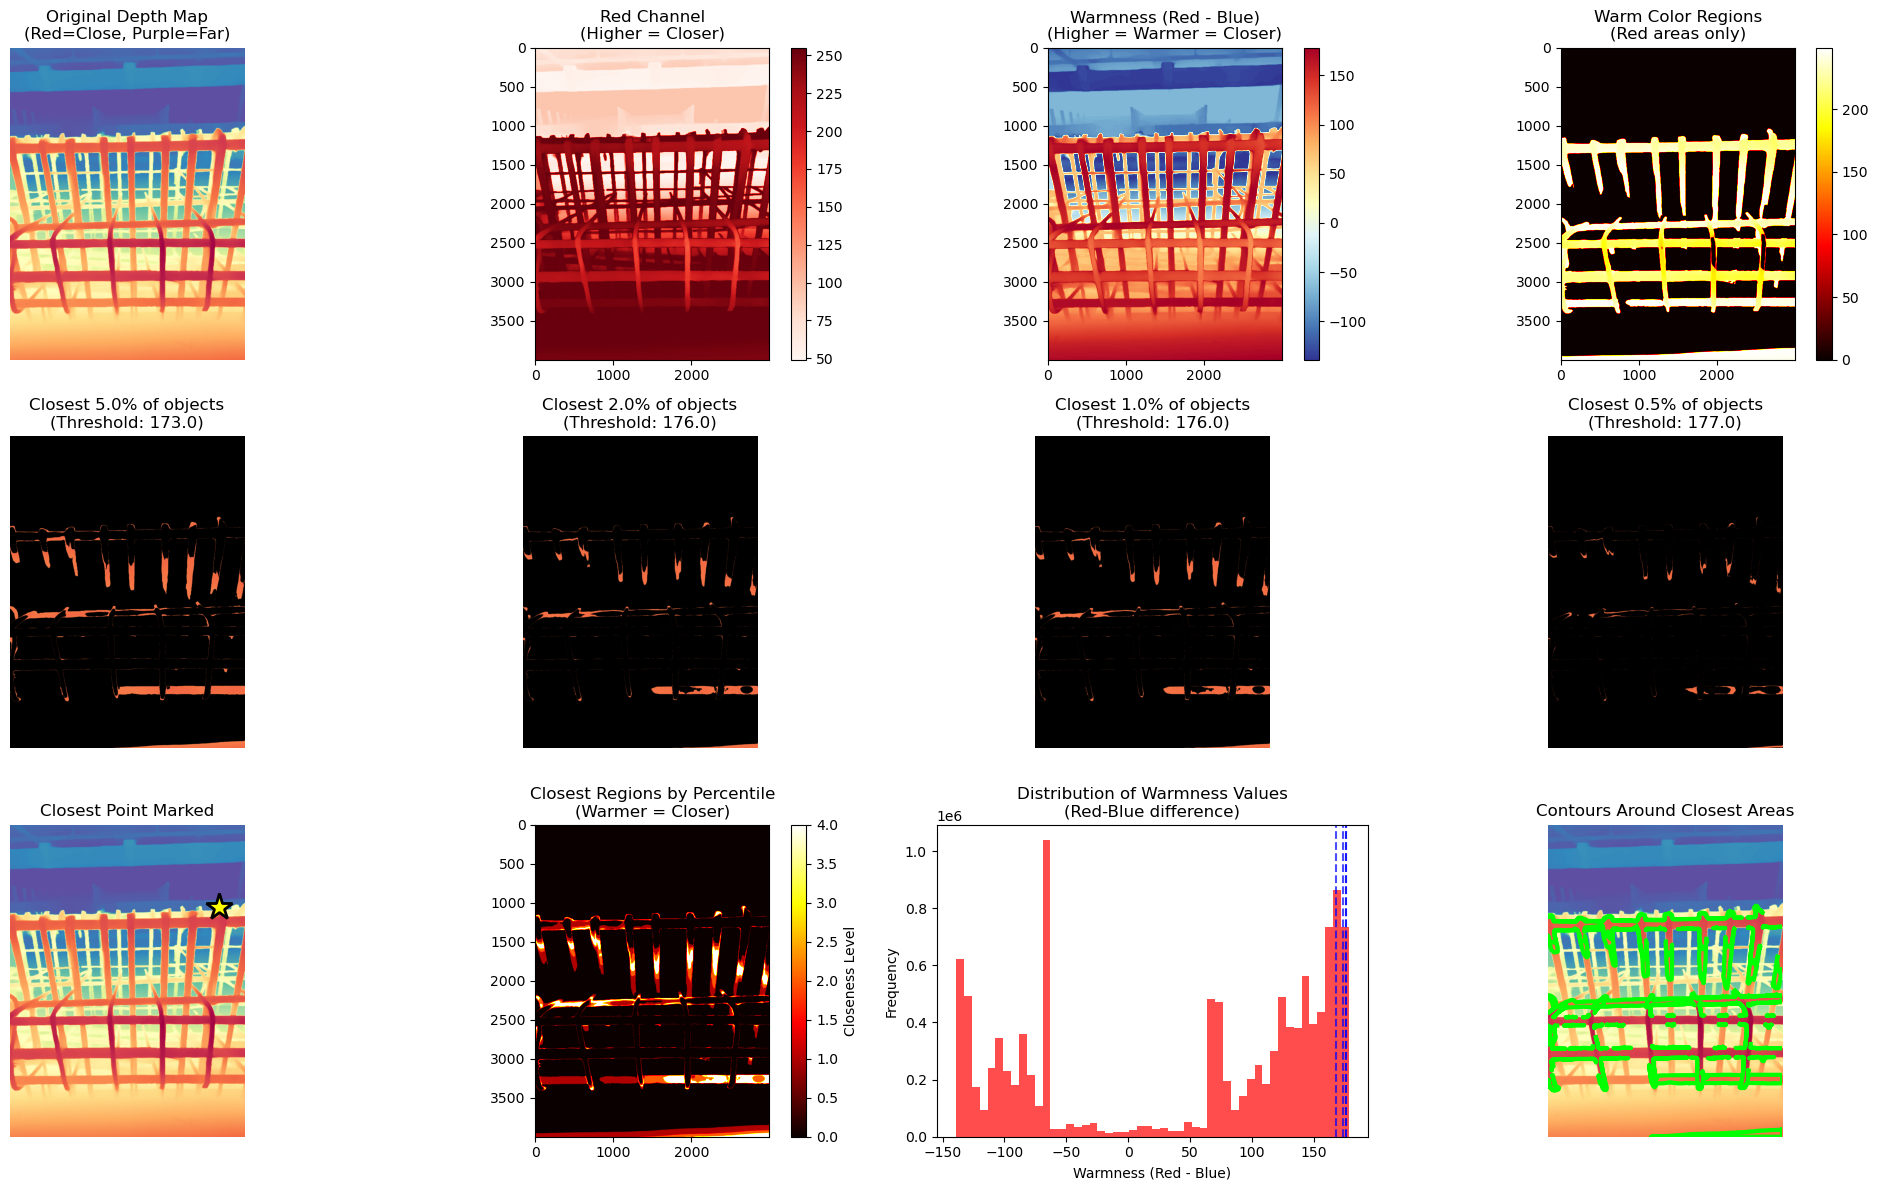


Color Analysis:
Red channel range: 49 - 255
Blue channel range: 66 - 190
Warmness range: -139.00 - 178.00


In [85]:
# Updated code to find closest objects (red/warm colors) in depth map

# Since closer = redder, let's focus on red channel and warm colors
red_channel = depth_map[:,:,0]
green_channel = depth_map[:,:,1] 
blue_channel = depth_map[:,:,2]

# Method 1: Use red channel directly (closest objects have highest red values)
closest_by_red = red_channel

# Method 2: Create a "warmness" metric (red - blue)
# Higher values = warmer colors = closer objects
warmness = red_channel.astype(float) - blue_channel.astype(float)

# Method 3: Create a color-based distance metric
# Convert to HSV to get better color separation
hsv = cv2.cvtColor(depth_map, cv2.COLOR_RGB2HSV)
hue = hsv[:,:,0]
saturation = hsv[:,:,1]
value = hsv[:,:,2]

# Red hue is around 0-10 and 350-360 (in OpenCV: 0-5 and 175-180)
# Create mask for red/warm colors
red_mask = (hue <= 10) | (hue >= 170)  # Red colors
warm_colors = red_mask.astype(float) * value  # Red areas weighted by brightness

plt.figure(figsize=(20, 12))

# Display original depth map
plt.subplot(3, 4, 1)
plt.imshow(depth_map)
plt.title('Original Depth Map\n(Red=Close, Purple=Far)')
plt.axis('off')

# Show different methods to find closest objects
plt.subplot(3, 4, 2)
plt.imshow(red_channel, cmap='Reds')
plt.title('Red Channel\n(Higher = Closer)')
plt.colorbar()

plt.subplot(3, 4, 3)
plt.imshow(warmness, cmap='RdYlBu_r')  # Red-Yellow-Blue reversed
plt.title('Warmness (Red - Blue)\n(Higher = Warmer = Closer)')
plt.colorbar()

plt.subplot(3, 4, 4)
plt.imshow(warm_colors, cmap='hot')
plt.title('Warm Color Regions\n(Red areas only)')
plt.colorbar()

# Find closest objects using different percentiles
closest_percentiles = [95, 98, 99, 99.5]  # Top 5%, 2%, 1%, 0.5%

for i, percentile in enumerate(closest_percentiles):
    threshold = np.percentile(warmness, percentile)
    closest_mask = warmness >= threshold
    
    # Create closest area visualization
    closest_area = np.zeros_like(depth_map)
    closest_area[closest_mask] = depth_map[closest_mask]
    
    plt.subplot(3, 4, i + 5)
    plt.imshow(closest_area)
    plt.title(f'Closest {100-percentile:.1f}% of objects\n(Threshold: {threshold:.1f})')
    plt.axis('off')

# Find the single closest point
max_warmness_idx = np.unravel_index(np.argmax(warmness), warmness.shape)
print(f"Closest point location: Row {max_warmness_idx[0]}, Col {max_warmness_idx[1]}")
print(f"Closest point warmness: {warmness[max_warmness_idx]:.2f}")
print(f"Closest point RGB: {depth_map[max_warmness_idx]}")

# Create a visualization with the closest point marked
plt.subplot(3, 4, 9)
plt.imshow(depth_map)
plt.plot(max_warmness_idx[1], max_warmness_idx[0], 'yellow', marker='*', markersize=20, 
         markeredgecolor='black', markeredgewidth=2)
plt.title('Closest Point Marked')
plt.axis('off')

# Show closest regions with different colors
plt.subplot(3, 4, 10)
closest_regions = np.zeros_like(warmness)
for i, percentile in enumerate([90, 95, 98, 99]):
    threshold = np.percentile(warmness, percentile)
    mask = warmness >= threshold
    closest_regions[mask] = i + 1

plt.imshow(closest_regions, cmap='hot')
plt.title('Closest Regions by Percentile\n(Warmer = Closer)')
plt.colorbar(label='Closeness Level')

# Show histogram of warmness values
plt.subplot(3, 4, 11)
plt.hist(warmness.flatten(), bins=50, alpha=0.7, color='red')
plt.title('Distribution of Warmness Values\n(Red-Blue difference)')
plt.xlabel('Warmness (Red - Blue)')
plt.ylabel('Frequency')
# Add lines for different percentiles
for percentile in [90, 95, 98, 99]:
    threshold = np.percentile(warmness, percentile)
    plt.axvline(threshold, color='blue', linestyle='--', alpha=0.7)

# Show the closest area with contours
plt.subplot(3, 4, 12)
threshold = np.percentile(warmness, 95)  # Top 5% closest
closest_mask = warmness >= threshold
contours, _ = cv2.findContours(closest_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

plt.imshow(depth_map)
# Draw contours around closest areas
for contour in contours:
    if cv2.contourArea(contour) > 50:  # Filter small contours
        contour_points = contour.reshape(-1, 2)
        plt.plot(contour_points[:, 0], contour_points[:, 1], 'lime', linewidth=3)

plt.title('Contours Around Closest Areas')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print color analysis
print(f"\nColor Analysis:")
print(f"Red channel range: {red_channel.min()} - {red_channel.max()}")
print(f"Blue channel range: {blue_channel.min()} - {blue_channel.max()}")
print(f"Warmness range: {warmness.min():.2f} - {warmness.max():.2f}")